<a id = 'title'></a>
# Hooked on Books: Advanced Modeling

**Author:** Quinci Birker

## Introduction

This notebook includes advanced modeling, following the second round of feature engineering. 
The original dataset included just over 52,000 books/rows and 25 columns. After data cleaning and feature engineering the dataset has just over 41,000 books/rows and 458 columns.

#### Summary from the First Round of Modeling

The initial models showed modest performance, leading to further refinement of features. The model summary below outlines the baseline results:


|     | Model Type               | Train Accuracy | Test Accuracy | Precision | Recall | Notes                    |
|-----|--------------------------|----------------|---------------|-----------|--------|--------------------------|
| 1.  | Logistic Regression      | 62%            | 52%           | 52%       | 97%    | Baseline/No parameters   |
| 2.  | Random Forest Classifier | 100%           | 52%           | 52%       | 100%   | Grid search performed    |
| 3.  | XGBoost                  | 81%            | 53%           | 53%       | 98%    | No grid search performed |

#### Enhancements in Second Round

To improve these scores, the second round of feature engineering focused on the book descriptions and publisher data. We utilized Text Preprocessing with TF-IDF Vectorization, keeping the top 400 words from descriptions, and incorporated the top 20 publishers based on their frequency. This approach is expected to provide more useful insights into the text data and its correlation with book ratings.


## Table of Contents

---------------------------------------
1. [Data Dictionary](#DD)
2. [Import Dataset and Libraries](#import)
3. [Logistic Regression - Baseline Modeling](#base)    
4. [Random Forest Classifier](#RFC)
5. [XGBoost](#XGB)
6. [Summary & Insights](#summary)
---------------------------------------

<a id = 'DD'></a>
##  Data Dictionary 

After data cleaning and data engineering, these are the following variables that will be used in the modeling process.

| Features       | Description                                                  |
|----------------|--------------------------------------------------------------|
| pages          | The number of pages in the book.                             |
| numRatings     | The number of ratings the book has received.                 |
| bbeScore       | Score in Best Books Ever list.                               |
| year           | Year of publication.                                         |
| month          | Month of publication.                                        |
| series_bool    | Indicates whether the book is part of a series.              |
| genre_count    | The number of genres the book is categorized under.          |
| genres_        | Top genres of the book.                                      |
| description_   | The top words found in the book's description.               |
| publisher_     | The top publishers of the book.                              |

| Target Variable | Description                                                  |
|-----------------|--------------------------------------------------------------|
| rating          | Book rating: 1 for good rating and 0 for not a good rating.  |


<a id = 'import'></a>
## Import Dataset and Libraries

In [1]:
# Import libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Read in the training dataset
X_train = pd.read_csv('data/X_train_2.csv', index_col=0)
y_train = pd.read_csv('data/y_train_2.csv', index_col=0)

# Read in the testing dataset
X_test = pd.read_csv('data/X_test_2.csv', index_col=0)
y_test = pd.read_csv('data/y_test_2.csv', index_col=0)

##### Sanity check training dataset

In [3]:
X_train.head()

,pages,numRatings,bbeScore,year,month,series_bool,genre_count,publisher_unknown,publisher_Vintage,publisher_HarperCollins,...,desc_would,desc_write,desc_writer,desc_written,desc_wrong,desc_year,desc_yet,desc_york,desc_young,desc_–
0,22.0,666,89,1974,1,0,52,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,176.0,161,83,1983,1,0,95,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,339.0,2535,24,2014,5,1,171,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.105272,0.0,0.0,0.0,0.0
3,201.0,17367,370,2009,7,0,139,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,224.0,94434,389,2016,11,0,125,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.208217,0.0,0.0,0.0,0.0


In [4]:
X_train.shape

(33041, 458)

In [5]:
y_train.head()

,rating
35783,1
39773,0
51074,0
7233,1
6868,0


In [6]:
y_train.shape

(33041, 1)

Scikit-Learn models expect the target variable to be a 1D array, so this will need to be reshaped

In [7]:
# Reshape y_train
y_train = y_train.values.ravel()
y_train.shape

(33041,)

Notes:
- The X_train and y_train look good.
- There are 33041 rows and 458 columns in the X_train

##### Sanity check testing dataset

In [8]:
X_test.head()

,pages,numRatings,bbeScore,year,month,series_bool,genre_count,publisher_unknown,publisher_Vintage,publisher_HarperCollins,...,desc_would,desc_write,desc_writer,desc_written,desc_wrong,desc_year,desc_yet,desc_york,desc_young,desc_–
0,346.0,1864,92,2015,9,1,147,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
1,160.0,12646,194,2002,1,1,140,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
2,513.0,62049,289,2019,9,1,131,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.112830,0.15885,0.0,0.0,0.0
3,432.0,3347,88,2012,3,0,127,0,0,0,...,0.0,0.106363,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
4,345.0,115,190,2014,6,1,65,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.181669,0.00000,0.0,0.0,0.0


In [9]:
X_test.shape

(8261, 458)

In [10]:
y_test.head()

,rating
33489,1
12086,0
8714,1
36527,1
12745,0


In [11]:
y_test.shape

(8261, 1)

Scikit-Learn models expect the target variable to be a 1D array, so this will need to be reshaped

In [12]:
# Reshape the y_test
y_test = y_test.values.ravel()
y_test.shape

(8261,)

Notes:
- The X_test and y_test look good.
- There are 8261 rows and 458 columns in the X_test

<a id = 'base'></a>
## Baseline Modeling

The baseline will be a logistic regression model. This will be used for future testing in how other models perform.

The model will predict whether a book has a good rating (1) or a bad rating (0).<a id = 'base_model'></a>


<a id = 'scale'></a>
##### Scale the data

Scaling ensures that each feature equally contributes to the modeling process, enhancing model performance. Consider the difference between the 'pages' and 'month' columns in this dataset: 'pages' varies across a range of over 3,000, where 'month' only goes up to 12. Without scaling, the model could disproportionately emphasize 'pages' due to its broader range.

The scaler of choice is the Standard Scaler, where the scaled distribution is centered at 0 and the variance will be based on the number of standard deviation away from the mean (the center). The reason for using this scaler is that in many cases, the Standard Scaler is often preferred and shows good performance.  

Since the majority of columns are binary, only the non-binary columns will be scaled. 
First, seperate the binary from non-binary columns and then apply the standard scaler to only the non-binary columns. 

**Reference:** BrainStation's Scaling kickoff notebook

In [13]:
# Identify non-binary columns
# non_binary_cols = [col for col in X_train_df_final.columns if len(X_train_df_final[col].unique()) > 2]
non_binary_cols = ['pages', 'numRatings', 'bbeScore', 'year', 'month']

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale only non-binary columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[non_binary_cols] = scaler.fit_transform(X_train[non_binary_cols])
X_test_scaled[non_binary_cols] = scaler.transform(X_test[non_binary_cols])

In [18]:
X_train_scaled.head()

,pages,numRatings,bbeScore,year,month,series_bool,genre_count,publisher_unknown,publisher_Vintage,publisher_HarperCollins,...,desc_would,desc_write,desc_writer,desc_written,desc_wrong,desc_year,desc_yet,desc_york,desc_young,desc_–
0,-1.307800,-0.190830,-0.059819,-3.285928,-1.494442,0,52,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,-0.672294,-0.195213,-0.059966,-2.360628,-1.494442,0,95,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0.000353,-0.174606,-0.061417,0.826515,-0.328749,1,171,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.105272,0.0,0.0,0.000000,0.0
3,-0.569127,-0.045860,-0.052912,0.312460,0.254097,0,139,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,-0.474214,0.623102,-0.052445,1.032137,1.419789,0,125,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.208217,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33036,-0.507227,-0.179502,-0.060065,-0.304407,1.128366,1,113,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.162758,0.0
33037,-1.184000,-0.196029,-0.060532,0.826515,-1.494442,0,9,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
33038,-0.012027,-0.182497,-0.060188,0.826515,-1.494442,1,141,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
33039,0.202559,-0.050904,-0.053870,0.826515,-1.203019,1,137,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [14]:
# Instantiate and fit logisitc regression
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

# Train and test scores
print(f'Train score: {logreg.score(X_train_scaled, y_train)}')
print(f'Test score: {logreg.score(X_test_scaled, y_test)}')

Train score: 0.6499803274719288
Test score: 0.5202759956421741


/Users/quincibirker/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
# Make predictions on the test data
y_pred_logreg = logreg.predict(X_test_scaled)

Insights: 
- The baseline logisitc regression has a train score of 64 percent and a test score of 52 percent. There seems to be overfitting and the overall test accuracy is not strong. This will still be used as a baseline and hopefully testing out different models will improve the prediction accuracy for the test set.

<a id = 'F1.1'></a>
##### Feature Importance: Looking at the Coefficients and Odds Ratio 

Things to note about the coefficient and odds ratio:

Coefficients: 
- The size of the coefficient indicates the strength of the association between the predictor and the outcome
- Larger absolute values mean a stronger relationship.

Odds ratio: 
- The ratio between the odds of an outcome happening
- Odds ratio > 1 means that the event is more likely to occur as the predictor increases
- Odds ratio < 1 means that the event is less likely to occur as the predictor increases
- Odds ratio = 1 means that there is no effect from the predictor variable


**Reference:** Brainstation's Logisitc Regression notebook

In [18]:
# Extract the coefficients
coefficients = logreg.coef_[0]

# Calculate the odds ratios
odds_ratio = np.exp(coefficients)

# Get the feature names
feature_names = X_train.columns

# Create a DataFrame with feature names, coefficients and odds ratios
feature_coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds_ratio': odds_ratio
})

# Sort the coefficients from highest to lowest
feature_coefficients = feature_coefficients.sort_values(by='Coefficient', ascending=False)

# Display 
feature_coefficients

,Feature,Coefficient,Odds_ratio
5,series_bool,0.801422,2.228709
0,pages,0.495778,1.641775
31,genre_Childrens,0.461944,1.587157
32,genre_Classics,0.387424,1.473181
34,genre_Contemporary Romance,0.283771,1.328129
...,...,...,...
55,genre_Thriller,-0.405328,0.666758
51,genre_Science Fiction,-0.513951,0.598128
47,genre_Novels,-0.544186,0.580314
45,genre_Mystery,-0.623852,0.535876


Insights:

Top Positive Influences on Rating:
- Series Books (series_bool): With a coefficient of 0.80 and an odds ratio of 2.23, this feature has the largest positive influence among the listed features. Books that are part of a series are more than twice as likely to receive a good rating compared to those that are not in a series.
- Pages (pages): Longer books are also more likely to receive a good rating. The positive coefficient of 0.5 and the odds ratio 1.64 suggest that each additional page increases the odds of a good rating.
- Specific Genres (Children's/Classics/Contemporary Romance...): These genres have positive coefficients, indicating that books in these genres are more likely to be rated positively.

Top Negative Influences on Rating:
- Mystery and Chick Lit genres have the highest negative coefficients, meaning that books under these genres are more likely to be given a negative review.

##### Confusion Matrix

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.52      0.02      0.04      3968
           1       0.52      0.98      0.68      4293

    accuracy                           0.52      8261
   macro avg       0.52      0.50      0.36      8261
weighted avg       0.52      0.52      0.37      8261



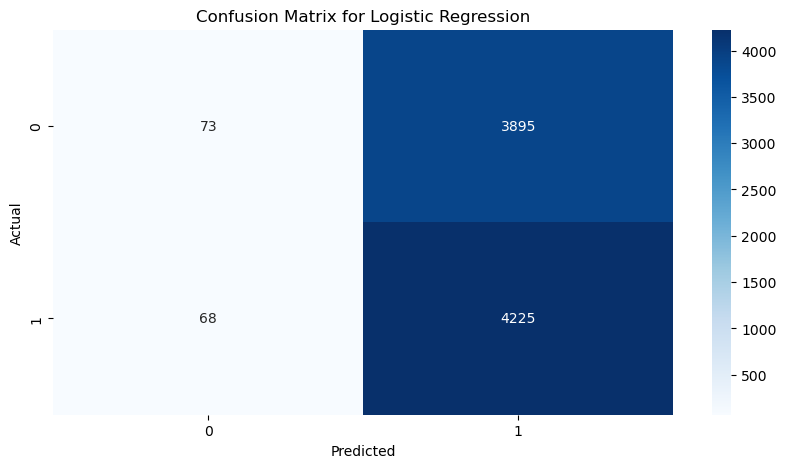

In [19]:
# Classification report
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_logreg))

# Generate the confusion matrix
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)

# Confusion matrix heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### Model Summary

|    | Model Type          | Train Accuracy | Test Accuracy | Precision | Recall | Notes                  |
|----|---------------------|----------------|---------------|-----------|--------|------------------------|
| 1. | Logistic Regression | 62%            | 52%           | 52%       | 97%    | Baseline/No parameters |

<a id = 'RFC'></a>
## Random Forest Classifier

##### Random Search

To efficiently tune hyperparameters, I'll start with a random search to quickly explore a wide range of options. Then, using the insights gained, I'll conduct a more targeted grid search in a narrowed range. This approach combines the speed of random search with the thoroughness of grid search for better results.

In [29]:
# Initialize the classifier
rf = RandomForestClassifier(random_state=55)

# Define the parameter space
param_distributions = {
    'max_depth':list(np.arange(10, 100, step=10)) + [None],
    'n_estimators':np.arange(10, 500, step=50),
    'max_features':randint(1,7),
    'criterion':['gini','entropy'],
    'min_samples_leaf':randint(1,4),
    'min_samples_split':np.arange(2, 10, step=2)
}

# Set up the random search with cross-validation
random_search = RandomizedSearchCV(rf, param_distributions=param_distributions, 
                                   n_iter=50, cv=5, verbose=2, random_state=55)

# Fit the random search model
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", random_search.best_params_)

# Use the best estimator to make predictions
best_rf = random_search.best_estimator_
y_pred_RFC = best_rf.predict(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=4, n_estimators=260; total time=   3.6s
[CV] END criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=4, n_estimators=260; total time=   3.4s
[CV] END criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=4, n_estimators=260; total time=   3.4s
[CV] END criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=4, n_estimators=260; total time=   3.5s
[CV] END criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=4, n_estimators=260; total time=   3.5s
[CV] END criterion=entropy, max_depth=60, max_features=4, min_samples_leaf=2, min_samples_split=6, n_estimators=10; total time=   0.3s
[CV] END criterion=entropy, max_depth=60, max_features=4, min_samples_leaf=2, min_samples_split=6, n_estimators=10; total t

[CV] END criterion=gini, max_depth=40, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=60; total time=   1.4s
[CV] END criterion=gini, max_depth=40, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=60; total time=   1.4s
[CV] END criterion=gini, max_depth=40, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=60; total time=   1.3s
[CV] END criterion=gini, max_depth=40, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=60; total time=   1.5s
[CV] END criterion=gini, max_depth=30, max_features=1, min_samples_leaf=2, min_samples_split=2, n_estimators=160; total time=   1.4s
[CV] END criterion=gini, max_depth=30, max_features=1, min_samples_leaf=2, min_samples_split=2, n_estimators=160; total time=   1.3s
[CV] END criterion=gini, max_depth=30, max_features=1, min_samples_leaf=2, min_samples_split=2, n_estimators=160; total time=   1.3s
[CV] END criterion=gini, max_depth=30, max_features=1, min_samples_leaf=2

[CV] END criterion=entropy, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END criterion=entropy, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END criterion=entropy, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=  13.1s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=  13.2s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=  13.0s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=  13.0s
[CV] END criterion=entropy, max_depth=80, max_featu

[CV] END criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=4, n_estimators=110; total time=   2.6s
[CV] END criterion=gini, max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=4, n_estimators=60; total time=   2.1s
[CV] END criterion=gini, max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=4, n_estimators=60; total time=   2.0s
[CV] END criterion=gini, max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=4, n_estimators=60; total time=   2.0s
[CV] END criterion=gini, max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=4, n_estimators=60; total time=   2.0s
[CV] END criterion=gini, max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=4, n_estimators=60; total time=   2.0s
[CV] END criterion=entropy, max_depth=30, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=160; total time=   2.9s
[CV] END criterion=entropy, max_depth=30, max_features=3, min_samples_l

[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=  13.3s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=  13.9s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=  14.0s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=  13.7s
Best parameters found:  {'criterion': 'entropy', 'max_depth': 80, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 310}


Best parameters found: Best parameters found:  {'criterion': 'entropy', 'max_depth': 80, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 310}

##### Check model accuracy with the best parameters

In [31]:
accuracy = best_rf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5988379130855829


##### Perform a grid search

In [30]:
# Initialize the classifier
rf = RandomForestClassifier(random_state=55)

# Define the parameter grid
param_grid = {
    'criterion': ['entropy'],  # No change needed as it's categorical
    'max_depth': [60, 70, 80],
    'max_features': [4, 5, 6],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [280, 290, 310]
}

# Set up the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best score is: "+str(grid_search.best_score_))

# Use the best estimator to make predictions
best_rf = grid_search.best_estimator_
y_pred_RFC = best_rf.predict(X_test)

Best parameters found:  {'criterion': 'entropy', 'max_depth': 70, 'max_features': 6, 'min_samples_split': 4, 'n_estimators': 310}
Best score is: 0.6878120194891624


Best parameters found:  
- 'criterion': 'entropy'
- 'max_depth': 70
- 'max_features': 6
- 'min_samples_split': 4
- 'n_estimators': 310

##### Random Forest Model with new parameters

In [33]:
params = {
    'criterion': 'entropy',
    'max_depth': 70,  
    'max_features': 6,  
    'min_samples_split': 4,  
    'n_estimators': 310  
}

# Initialize the RandomForestClassifier with these parameters
rf_model = RandomForestClassifier(**params, random_state=55)

# Fit the model to your training data (assuming you have X_train and y_train)
rf_model.fit(X_train, y_train)

# Use rf_model to make predictions 
y_pred_RFC = rf_model.predict(X_test)

print(f'Train score: {rf_model.score(X_train, y_train)}')
print(f'Test score: {rf_model.score(X_test, y_test)}')

Train score: 0.995248327835114
Test score: 0.5988379130855829


##### Classification Report & Confusion Matrix

              precision    recall  f1-score   support

           0       0.76      0.24      0.37      3968
           1       0.57      0.93      0.71      4293

    accuracy                           0.60      8261
   macro avg       0.67      0.59      0.54      8261
weighted avg       0.66      0.60      0.54      8261



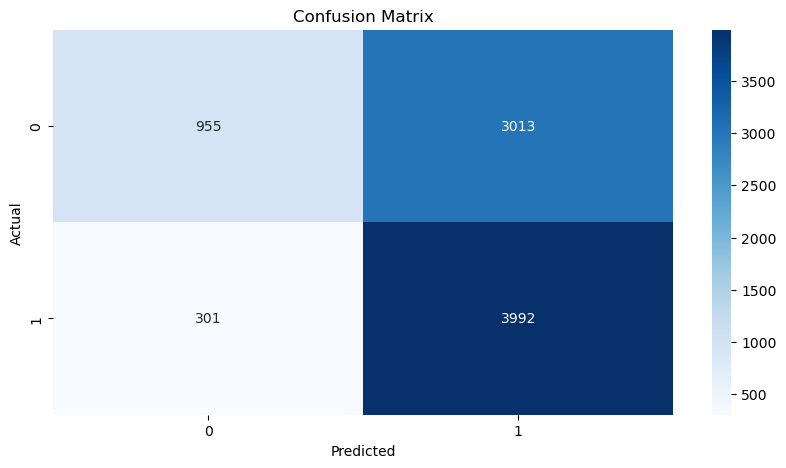

In [39]:
# Classification report
print(classification_report(y_test, y_pred_RFC))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_RFC)

# Confusion matrix heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues') 
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### Feature importance

In [35]:
feature_importances = rf_model.feature_importances_

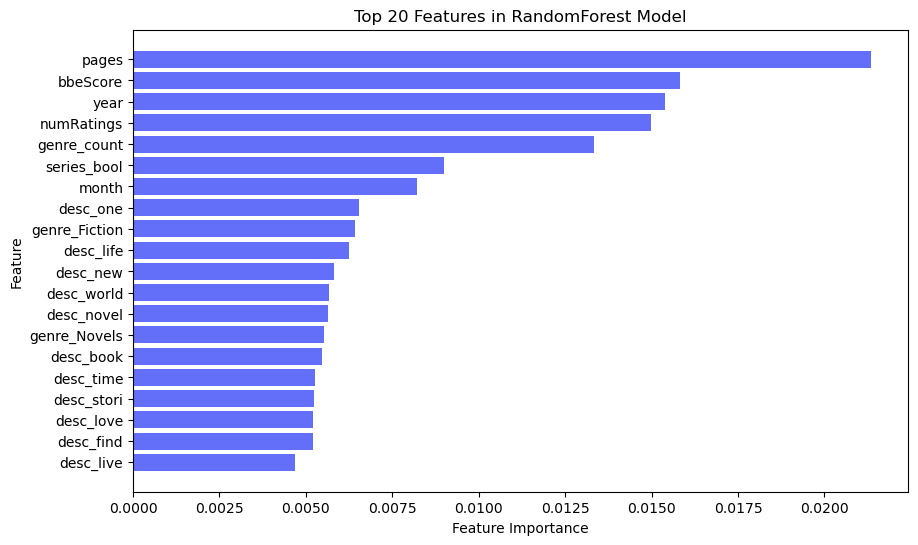

In [37]:
feature_names = X_train.columns if hasattr(X_train, 'columns') else np.arange(X_train.shape[1])

# Sorting the features with their importance
sorted_idx = np.argsort(feature_importances)[-20:]  # Get indices of top 20 features
sorted_importances = feature_importances[sorted_idx]
sorted_features = [feature_names[i] for i in sorted_idx]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='#636EF9')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 20 Features in RandomForest Model")
plt.show()

##### Model Summary

|    | Model Type               | Train Accuracy | Test Accuracy | Precision | Recall | Notes                  |
|----|--------------------------|----------------|---------------|-----------|--------|------------------------|
| 1. | Logistic Regression      | 62%            | 52%           | 52%       | 97%    | Baseline/No parameters |
| 2. | Random Forest Classifier | 100%           | 52%           | 52%       | 100%   | With grid search       |

<a id = 'XGB'></a>
## XGBoost Model

##### Perform random search for XGBoost

In [17]:
# Define hyperparameter space
params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

# Initialize the model
xgb_model = XGBClassifier()

# Random search
random_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=100, cv=5, verbose=2, random_state=55)
random_search.fit(X_train, y_train)

# Best parameters
print(random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9; total time=   3.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9; total time=   3.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9; total time=   3.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9; total time=   3.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9; total time=   3.9s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.6; total time=  15.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.6; total time=  11.8s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.6; total time=  14.9s
[CV] END colsa

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9; total time=   4.3s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9; total time=   5.5s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9; total time=   6.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9; total time=   5.6s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=4, n_estimators=400, subsample=0.9; total time=  13.2s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=4, n_estimators=400, subsample=0.9; total time=   9.6s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=4, n_estimators=400, subsample=0.9; total time=  12.6s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=4, n_estimators=400, subsample=0.9; total time=  13.2s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=4, n_estimators

[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.6; total time=   7.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.6; total time=   7.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.6; total time=   7.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.6; total time=   9.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.6; total time=   7.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.6; total time=   9.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.6; total time=   9.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.6; total time=   9.7s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimator

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.7; total time=  15.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.7; total time=  15.4s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9; total time=   3.7s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9; total time=   2.9s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9; total time=   3.8s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9; total time=   3.8s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9; total time=   3.7s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   3.0s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=10

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.6; total time=   8.6s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9; total time=   9.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9; total time=   7.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9; total time=   9.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9; total time=   9.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9; total time=   9.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   9.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   7.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=400, subsample=0.8; total time=  14.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=400, subsample=0.8; total time=  11.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=400, subsample=0.8; total time=  14.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=400, subsample=0.8; total time=  14.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=400, subsample=0.8; total time=  14.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   5.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   4.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   5.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=200,

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   7.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   9.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   9.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   9.7s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.6; total time=  11.3s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.6; total time=   8.8s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.6; total time=  12.4s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.6; total time=  11.9s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estima

[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=400, subsample=0.6; total time=  10.6s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=400, subsample=0.6; total time=  10.7s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=400, subsample=0.6; total time=  10.6s
{'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


Best parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

In [26]:
# Set the best parameters (from random search)
best_params = {
    'subsample': 0.8,
    'n_estimators': 300,
    'max_depth': 7,
    'learning_rate': 0.05,
    'colsample_bytree': 0.8
}

# Fit the model on training data with best parameters
xgb_model = XGBClassifier(**best_params)
xgb_model.fit(X_train, y_train)

# Make predictions for the training data
y_pred_train = xgb_model.predict(X_train)
predictions_train = [round(value) for value in y_pred_train]

# Make predictions for the test data
y_pred_test = xgb_model.predict(X_test)
predictions_test = [round(value) for value in y_pred_test]

# Evaluate predictions
train_accuracy = accuracy_score(y_train, predictions_train)
test_accuracy = accuracy_score(y_test, predictions_test)

print("Train Accuracy: {:.2f}%".format(train_accuracy * 100.0))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100.0))

Train Accuracy: 83.76%
Test Accuracy: 57.50%


##### Classification Report & Confusion Matrix

              precision    recall  f1-score   support

           0       0.75      0.17      0.28      3968
           1       0.55      0.95      0.70      4293

    accuracy                           0.57      8261
   macro avg       0.65      0.56      0.49      8261
weighted avg       0.65      0.57      0.50      8261



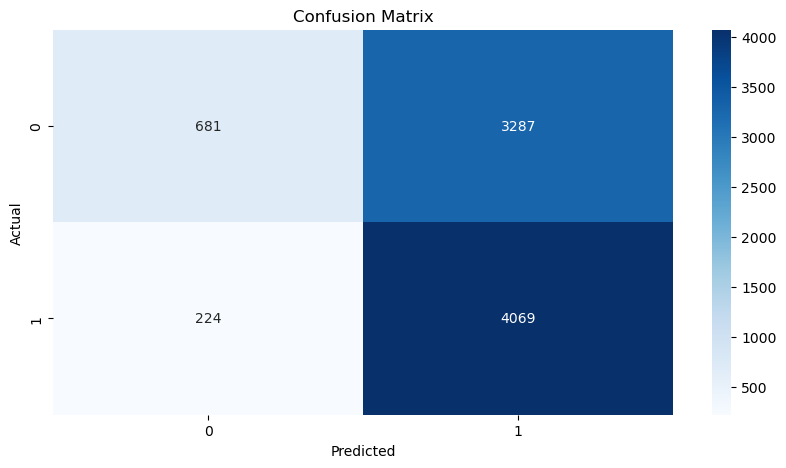

In [27]:
# Classification report
print(classification_report(y_test, predictions_test))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_test)

# Confusion matrix heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues') 
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### Perform grid search for XGBoost

In [24]:
# Parameter grid centered around the best parameters from random search
param_grid = {
    'subsample': [0.8, 0.85],
    'n_estimators': [250, 300, 350],
    'max_depth':  [5, 6, 7],
    'learning_rate': [0.05, 0.06],
    'colsample_bytree': [0.8, 0.85]
}

# Initialize the model
xgb_model = XGBClassifier()

# Grid search
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
best_parameters = grid_search.best_params_
print("Best Grid Search Parameters:", best_parameters)

KeyboardInterrupt: 

Best parameters from grid search:

In [28]:
# Fit the model on training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
# Fit the model on training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Make predictions for the training data
y_pred_train = xgb_model.predict(X_train)
predictions_train = [round(value) for value in y_pred_train]

# Make predictions for the test data
y_pred_test = xgb_model.predict(X_test)
predictions_test = [round(value) for value in y_pred_test]

# Evaluate predictions
train_accuracy = accuracy_score(y_train, predictions_train)
test_accuracy = accuracy_score(y_test, predictions_test)

print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0))
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Train Accuracy: 84.80%
Test Accuracy: 58.23%


##### Classification Report & Confusion Matrix

              precision    recall  f1-score   support

           0       0.72      0.22      0.33      3968
           1       0.56      0.92      0.70      4293

    accuracy                           0.58      8261
   macro avg       0.64      0.57      0.51      8261
weighted avg       0.63      0.58      0.52      8261



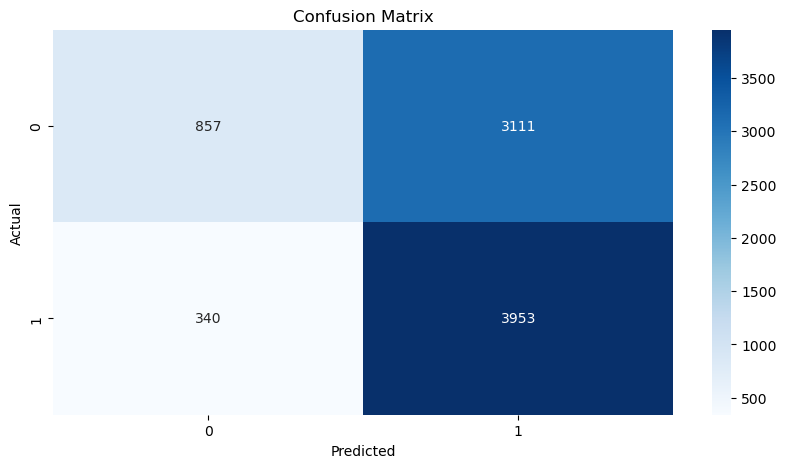

In [30]:
# Classification report
print(classification_report(y_test, predictions_test))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_test)

# Confusion matrix heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues') 
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### Model Summary

|     | Model Type               | Train Accuracy | Test Accuracy | Precision | Recall | Notes                    |
|-----|--------------------------|----------------|---------------|-----------|--------|--------------------------|
| 1.  | Logistic Regression      | 62%            | 52%           | 52%       | 97%    | Baseline/No parameters   |
| 2.  | Random Forest Classifier | 100%           | 52%           | 52%       | 100%   | Grid search performed    |
| 3.  | XGBoost                  | 81%            | 53%           | 53%       | 98%    | No grid search performed |

<a id = 'summary'></a>
## Summary & Insights


[Back to the top](#title)